## Studying features:

In [3]:
conda install --revision 0


^C

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
#Read the Bike Sharing Demand Training dataset, and see the general schema
df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
#checking the datatypes of each feature
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:
#checking whether there's missing data or not
(df.isna().sum() /df.shape[0]).round(2).sort_values()

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

In [ ]:
#show & study the data plots in order to determine which features to keep, which to normalize.. etc.
df.hist(bins=100, figsize=(50,50))
plt.show()

## Features tuning and normalization:

### Data input:
- **date-time** (keep) is a necessary feature as it studies the hourly change in bike rentals, which affects the target variable, and which will be parsed into **"months"**, **"days"** and **"hours"** features

In [ ]:
#Parsing datetime into its attributes and adding them as rows
datetime = pd.DatetimeIndex(df["datetime"])

#df.insert takes 3 parameters: the index where the column is going to be inserted, title and data.
df.insert(df.shape[1]-1, "month", datetime.month)
df.insert(df.shape[1]-1, "day", datetime.day)
df.insert(df.shape[1]-1, "hour", datetime.hour)

df

## Checking correlations and removing them:

In [7]:
#These lobraries are required for dataframe correlation study 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)

In [8]:
#Studying the features' correlation, and creating an EDA out of it
count = df["count"]
EDA = df.iloc[:,1:-1]
label_encoder = LabelEncoder()
EDA.iloc[:,0] = label_encoder.fit_transform(EDA.iloc[:,0]).astype('float64')
corr = EDA.corr()
EDA

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,month,day,hour
0,0.0,0,0,1,9.84,14.395,81,0.0000,3,13,1,1,0
1,0.0,0,0,1,9.02,13.635,80,0.0000,8,32,1,1,1
2,0.0,0,0,1,9.02,13.635,80,0.0000,5,27,1,1,2
3,0.0,0,0,1,9.84,14.395,75,0.0000,3,10,1,1,3
4,0.0,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,3.0,0,1,1,15.58,19.695,50,26.0027,7,329,12,19,19
10882,3.0,0,1,1,14.76,17.425,57,15.0013,10,231,12,19,20
10883,3.0,0,1,1,13.94,15.910,61,15.0013,4,164,12,19,21
10884,3.0,0,1,1,13.94,17.425,61,6.0032,12,117,12,19,22


<AxesSubplot:>

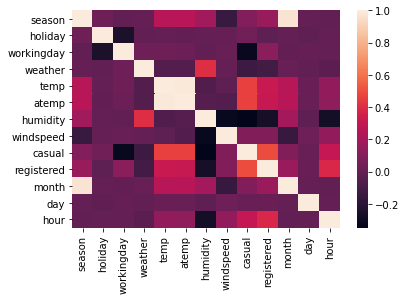

In [9]:
#Correlation map visualization
sns.heatmap(corr)

In [10]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
                
selected_columns = corr.columns[columns]
EDA = EDA[selected_columns]

corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,-0.150192,0.036157,0.146631
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.092722,0.014109,0.302045
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.169451,0.019111,0.380540


## Studying the uncorrelated and tuning them:

### Data Inputs
- **season** (drop) feature is way too general for the model, therefore, studying daily weather helps more, meaning: "season" feature is already reduced into "weather", "temp", "humidity" and "windspeed" features.
- **holidays** (drop) are usually 0s in working days, therefore these 2 can be reduced into "workingdays" feature only.
- **workingdays** (keep) is a necessary feature to study the rental during work days, which affects the target variable.
- **weather** (keep) is a necessary feature as it studies the weather change during a day, which affects the target variable.
- **temp** (keep) is a necessary feature as it studies the actual tempreture, which affects the target variable.
- **atemp** (removed) as the correlation between it and temp is high, besides the fact that atemp is the feeling people get from data, therefore we drop it.
- **humidity** (keep) is a necessary feature as it senses the humidity of the weather, which affects the target variable.
- **windspeed** (keep) is necessary as it defines how many rentals there will be, which affects the target variable.


### Target Variables
- **casual** (drop) is summed into another feature, therefore, no need for it as there's a bigger variable it's summed to.
- **registered** (drop) is summed into another feature, therefore, no need for it as there's a bigger variable it's summed to.
- **sum** (keep) the sum of casual and registered, therefore it's essential to predict the number of rentals.

In [11]:
EDA.drop(['registered', 'casual'], axis = 1, inplace = True)
EDA["count"] = count
EDA

,season,holiday,workingday,weather,temp,humidity,windspeed,day,hour,count
0,0.0,0,0,1,9.84,81,0.0000,1,0,16
1,0.0,0,0,1,9.02,80,0.0000,1,1,40
2,0.0,0,0,1,9.02,80,0.0000,1,2,32
3,0.0,0,0,1,9.84,75,0.0000,1,3,13
4,0.0,0,0,1,9.84,75,0.0000,1,4,1
...,...,...,...,...,...,...,...,...,...,...
10881,3.0,0,1,1,15.58,50,26.0027,19,19,336
10882,3.0,0,1,1,14.76,57,15.0013,19,20,241
10883,3.0,0,1,1,13.94,61,15.0013,19,21,168
10884,3.0,0,1,1,13.94,61,6.0032,19,22,129


## Normalizing EDA data:

In [12]:
column_maxes = EDA.max()
normalized = EDA/column_maxes
normalized

,season,holiday,workingday,weather,temp,humidity,windspeed,day,hour,count
0,0.0,0.0,0.0,0.25,0.24,0.81,0.000000,0.052632,0.000000,0.016377
1,0.0,0.0,0.0,0.25,0.22,0.80,0.000000,0.052632,0.043478,0.040942
2,0.0,0.0,0.0,0.25,0.22,0.80,0.000000,0.052632,0.086957,0.032753
3,0.0,0.0,0.0,0.25,0.24,0.75,0.000000,0.052632,0.130435,0.013306
4,0.0,0.0,0.0,0.25,0.24,0.75,0.000000,0.052632,0.173913,0.001024
...,...,...,...,...,...,...,...,...,...,...
10881,1.0,0.0,1.0,0.25,0.38,0.50,0.456213,1.000000,0.826087,0.343910
10882,1.0,0.0,1.0,0.25,0.36,0.57,0.263195,1.000000,0.869565,0.246673
10883,1.0,0.0,1.0,0.25,0.34,0.61,0.263195,1.000000,0.913043,0.171955
10884,1.0,0.0,1.0,0.25,0.34,0.61,0.105325,1.000000,0.956522,0.132037


## Training the model

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [14]:
X_train = EDA.drop(columns = "count")
y_train = EDA["count"]

degree= 4
pr=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pr.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

## Pickling the model

In [15]:
import pickle

In [16]:
pickle.dump(pr, open('./model.txt', 'wb'))
loaded_model = pickle.load(open('./model.txt', 'rb'))

loaded_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])